In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Load train, val, test data
directory = "/Users/varunursekar/Projects/advDeepLearning/final_project/data/METR-LA/"
data = {}

for split in ['train','val','test']:
    data_split = np.load(directory+split+'.npz')
    data['x_'+split] = data_split['x']
    data['y_'+split] = data_split['y']

In [3]:
class ZScoreNormalizer:
    
    def __init__(self):
        self.means = None
        self.std = None
        self.adapted = False
    
    def reset(self):
        self.means = None
        self.std = None
        self.adapted = False
    
    def adapt(self,X):
        self.means = np.mean(X,axis=0,keepdims=True)
        self.std = np.std(X,axis=0,keepdims=True)
        self.adapted = True
    
    def transform(self,X):
        assert(list(X.shape)[1:]==list(self.means.shape)[1:])
        assert(self.adapted)
        return (X-self.means)/self.std
    
    def inverse_transform(self,X):
        assert(list(X.shape)[1:]==list(self.means.shape)[1:])
        assert(self.adapted)
        return self.std*X + self.means

# Obtain Z-scores for each input dimension
scaler = ZScoreNormalizer()
scaler.adapt(data['x_train'])

# Scale all data splits by training means and variances
scaled_data = {}
for key in data:
    scaled_data[key] = scaler.transform(data[key])
    
    
# Input and output dims
input_shape = tuple(list(data['x_train'].shape)[1:])
output_shape = tuple(list(data['y_train'].shape)[1:])
input_dims = np.product(input_shape)
output_dims = np.product(output_shape)

In [4]:
# Construct TF model here

# Simple FNN
model = tf.keras.Sequential([tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(units=256,activation='relu',),
                                                   #kernel_regularizer=tf.keras.regularizers.L2(0.01)),
                             #tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(units=256,activation='relu',),
                                                   #kernel_regularizer=tf.keras.regularizers.L2(0.01)),
                             #tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(units=output_dims,activation='linear'),
                             tf.keras.layers.Reshape(output_shape)])

Metal device set to: Apple M1 Max


2022-03-16 15:55:02.571029: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-16 15:55:02.571131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# hyperparameters and callbacks

BATCH_SIZE = 64
MAX_EPOCHS = 20

def scheduler(epoch, lr):
    if epoch<50:
        return lr
    elif epoch%20==0:
        return lr/10
    else:
        return lr
    
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(1e-3))

In [6]:
# Compile and fit model here

history = model.fit(x=scaled_data['x_train'], y=scaled_data['y_train'], 
                    batch_size=BATCH_SIZE, epochs=MAX_EPOCHS,
                    validation_data=(scaled_data['x_val'],scaled_data['y_val']),
                    callbacks=[callback_lr,callback_es])

Epoch 1/20


2022-03-16 15:55:02.910425: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  8/375 [..............................] - ETA: 2s - loss: 0.6384  

2022-03-16 15:55:03.138302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 3s 8ms/step - loss: 0.2505 - val_loss: 0.2218 - lr: 0.0010
Epoch 2/20


2022-03-16 15:55:06.191441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 3s 8ms/step - loss: 0.2033 - val_loss: 0.2085 - lr: 0.0010
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1940 - val_loss: 0.2147 - lr: 0.0010
Epoch 4/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1889 - val_loss: 0.2036 - lr: 0.0010
Epoch 5/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1813 - val_loss: 0.2029 - lr: 0.0010
Epoch 6/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1773 - val_loss: 0.2002 - lr: 0.0010
Epoch 7/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1766 - val_loss: 0.1954 - lr: 0.0010
Epoch 8/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1736 - val_loss: 0.2024 - lr: 0.0010
Epoch 9/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1722 - val_loss: 0.2008 - lr: 0.0010
Epoch 10/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1700 - val_loss: 0.1940 - lr: 

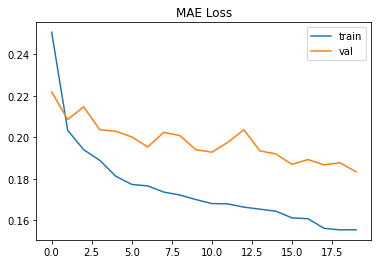

In [7]:
# Plot training and validation loss
plt.figure()
plt.title("MAE Loss")
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='val')
plt.legend()

In [8]:
# Compute unnormalized prediction loss

preds = {}

for split in ['test','val']:
    preds[split] = model.predict(scaled_data['x_'+split])
    preds[split] = scaler.inverse_transform(preds[split])

2022-03-16 15:56:04.159533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<BarContainer object of 12 artists>

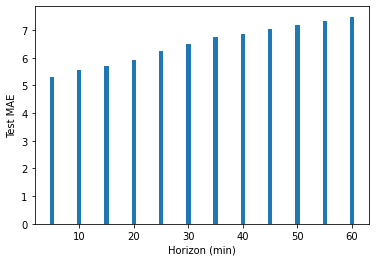

In [9]:
# MAE Loss
mae_losses = np.mean(np.abs(preds['test']-data['y_test']),axis=(0,2))[:,0]
plt.xlabel("Horizon (min)")
plt.ylabel("Test MAE")
plt.bar(np.arange(1,13)*5,mae_losses)

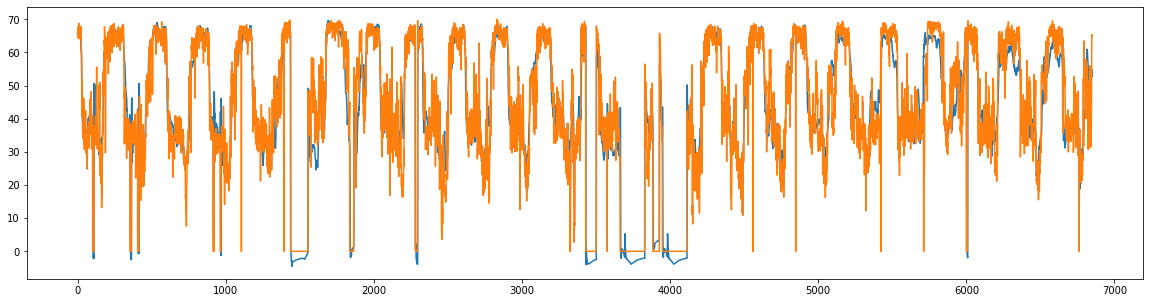

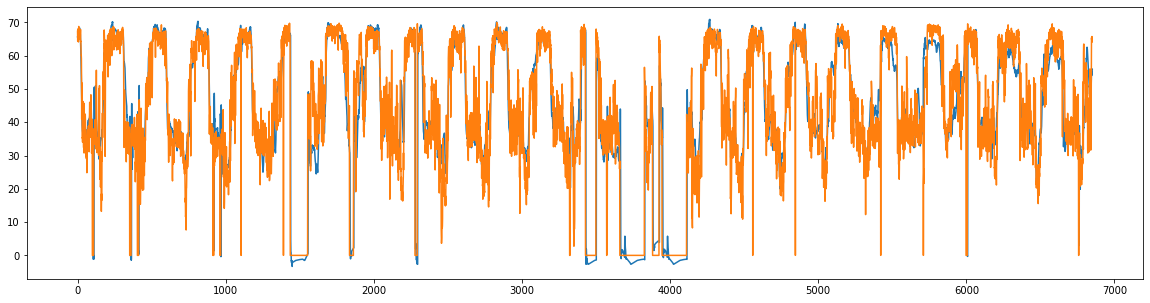

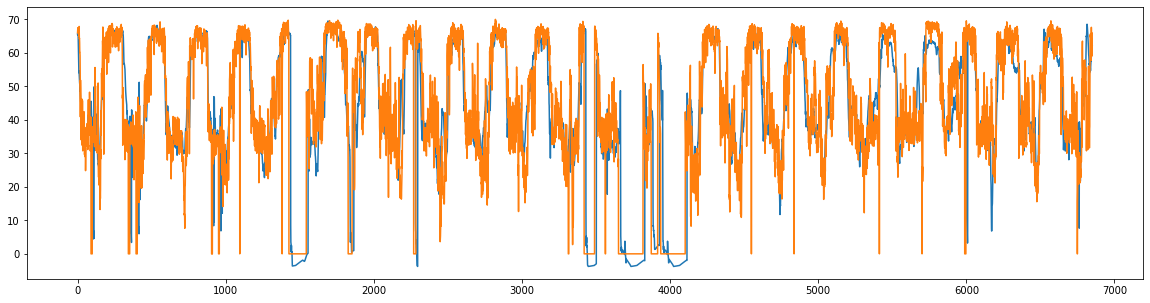

In [10]:
# Example 5 minute horizon prediction from Sensor 0
plt.figure(figsize=(20,5))
plt.plot(preds['test'][:,0,15,0])
plt.plot(data['y_test'][:,0,15,0])

# Example 15 minute horizon prediction from Sensor 0
plt.figure(figsize=(20,5))
plt.plot(preds['test'][:,2,15,0])
plt.plot(data['y_test'][:,2,15,0])

# Example 60 minute horizon prediction from Sensor 0
plt.figure(figsize=(20,5))
plt.plot(preds['test'][:,-1,15,0])
plt.plot(data['y_test'][:,-1,15,0])